# Проект для «Викишоп» с TF-IDF и BERT

Заказчиком проекта является Интернет-магазин «Викишоп». Целью проекта является построение модели машинного обучения, способной распознавать негативные отзывы клиентов магазина и отправлять их на модерацию. 

Для обучения модели заказчиком предоставлен набор данных toxic_comments.csv, в которых комментарии размечены на позитивные и негативные. 

Метрикой качества задана F1, значение которой должно быть не меньше 0.75.

## Подготовка

In [1]:
!pip install transformers

Импортируем необходимые библиотеки

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import catboost as cb
import torch
import transformers
import matplotlib.pyplot as plt
import seaborn as sns
import random
import nltk
import re
import warnings
warnings.filterwarnings('ignore')

from numpy.random import RandomState

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, StratifiedShuffleSplit

from sklearn.utils import shuffle
from sklearn. metrics import precision_recall_curve,recall_score, precision_score, f1_score 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

from tqdm import notebook
from tqdm.notebook import tqdm
tqdm.pandas()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Построение модели машинного обучения, определяющей тональность текста связано с машинной обработкой естественного языка. В этой связи предпримем следующий алгоритм действий:
-  изучим предоставленные данные;
-  обработаем и конвертируем текст, переведя в формат, пригодный для построения моделей машинного обучения;
-  построим бизлайн модель и несколько моделей с подбором гиперпараметров, подберем лучшую и протестируем;
-  напишем выводы.

### Изучение данных

Читаем файл

In [3]:
try:
    data = pd.read_csv("C:\\Users\\User\\Downloads\\toxic_comments.csv")
    data = data.drop('Unnamed: 0', axis=1)
except:

    data = pd.read_csv('/datasets/toxic_comments.csv')
    data = data.drop('Unnamed: 0', axis=1)

Выводим информацию о датасете

In [4]:
display(data)
data.info()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Проверяем наличие дубликатов 

In [5]:
print("Полных дубликатов:", data.duplicated().sum())
print("Дубликатов в столбце с текстом:",data['text'].duplicated().sum())

Полных дубликатов: 0
Дубликатов в столбце с текстом: 0


Проверяем корректность данных в целевом признаке

In [6]:
data['toxic'].sort_values().unique()

array([0, 1], dtype=int64)

Проверяем соотношение классов в целевом признаке

0    143106
1     16186
Name: toxic, dtype: int64

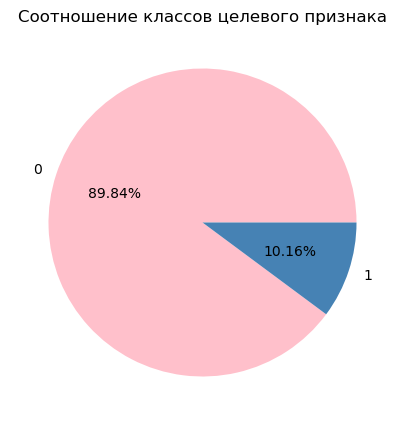

In [7]:
display(data['toxic'].value_counts())

a = data.groupby('toxic').size()
a.plot(kind='pie', subplots=True, colors = ['pink', 'steelblue'],autopct='%0.2f%%', figsize=(5, 5)) 
plt.title("Соотношение классов целевого признака")
plt.ylabel("")
plt.show()

Исходный датасет представлен 159292 объектами, признаком, представленным текстами комментариев (столбец'text') и целевым признаком - классифицированной по бинарному типу разметкой комментариев (столбец 'toxic'). В целевом признаке присутствует дисбаланс в соотношении 9:1 в сторону увеличения числа объектов отрицательного класса.

## Модели с преобразованием признаков TF-IDF

### Обработка данных

Для обработки естественного языка мы импортировали библиотеки nltk, re и необходимые модули из них. Для начала мы очистим текст от лишних символов, цифр, приведем все слова к нижнему регистру, разобъем его на токены (слова), удалим слова, не несущие смысловой нагрузки (стоп-слова) и лемматизируем текст (приведем слова к начальной форме). Для всех этих действий напишем специальную функцию, которую применим к столбцу с текстами.

Чтоб у нас остались исходные данные, для всех преобразований и построения моделей создадим копию датафрейма.

Создаем копию датафрейма

In [8]:
df = data.copy()
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Пишем функцию

In [9]:
stop_words = set(stopwords.words('english')) 
stop_words.remove('not')

def data_preprocessing(text):
    text =  re.sub(r"[^a-zA-Z]", ' ', text) # оставляем только буквы латинского алфавита
    text = text.strip() #убирание первого и последнего пробела
    text = re.sub(r' {1,10}', ' ', text) #замена множественных пробелов на один
    text = nltk.word_tokenize(text) # разбиваем на токены
    text = [word for word in text if word not in stop_words] # убираем стоп-слова английского языка
    text = " ".join(text) # объединяем элементы в строку
    return text # возвращаем преобразованный текст

Применяем функцию к столбцу с тексом, заменяя его очищенными данными

In [10]:
df['text'] = df['text'].apply(data_preprocessing) 

Смотрим как изменился текст 

In [11]:
print(data['text'][0])
print('')
print(df['text'][0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Explanation Why edits made username Hardcore Metallica Fan reverted They vandalisms closure GAs I voted New York Dolls FAC And please remove template talk page since I retired


In [12]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatiz(text):
    return " ".join([lemmatizer.lemmatize(w.lower(), get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])

In [13]:
text = "The striped bats are hanging on their feet for best"
print(text)
print(lemmatiz(text))

The striped bats are hanging on their feet for best
the strip bat be hang on their foot for best


Функция lemmatiz работает корректно, применим ее к столбцу датафрейма с текстами.

In [14]:
df['text'] = df['text'].progress_apply(lemmatiz) 

  0%|          | 0/159292 [00:00<?, ?it/s]

Сравним тексты до преобразования и после

In [15]:
print('Текст до преобразования: ', data['text'][0])
print('')
print('Текст после преобразования: ',df['text'][0])

Текст до преобразования:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Текст после преобразования:  explanation why edits make username hardcore metallica fan revert they vandalism closure gas i vote new york doll fac and please remove template talk page since i retire


Текст разбит на отдельные слова в нижнем регистре, не содержит цифры, знаки препинания, символы. По стандартному словарю из него удалены стоп-слова. 

In [16]:
df.head()

,text,toxic
0,explanation why edits make username hardcore m...,0
1,d aww he match background colour i seemingly s...,0
2,hey man i really not try edit war it guy const...,0
3,more i make real suggestion improvement i wond...,0
4,you sir hero any chance remember page,0


 <b>Вывод:</b> Перед нами поставлена задача построения модели машинного обучения, способной обрабатывать естественный язык. Исходный датасет представлен 159292 объектами, признаком, представленным текстами комментариев (столбец'text') и целевым признаком - классифицированной по бинарному типу разметкой комментариев (столбец 'toxic'). В целевом признаке присутствует дисбаланс в соотношении 9:1 в сторону увеличения числа объектов отрицательного класса.
    
В ходе подготовки данных  мы написали функции, применив которые к столбцу 'text', очистили признак от лишних символов, цифр, привели слова к нижнему регистру, разбили текст на токены (слова), удалили слова, не несущие смысловой нагрузки (стоп-слова) и лемматизировали (привели слова к начальной форме). 
</div>

### Подготовка данных

In [17]:
y = df['toxic'] # выделяем целевой признак
X = df.drop('toxic', axis=1) # выделяем признаки

In [18]:
STATE = RandomState(12345)

Делим данные на учебную и тестовую выборки

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  
                                                    train_size=0.9,  
                                                    random_state=STATE,
                                                    stratify= y,                          
                                                    shuffle=True)

print('Размеры выборок:')
print('train_df', X_train.shape, y_train.shape)
print('test_df', X_test.shape, y_test.shape)

Размеры выборок:
train_df (143362, 1) (143362,)
test_df (15930, 1) (15930,)


Проверяем соотношение классов в исходной, учебной и тестовой выборках

In [20]:
def ratio(sample):
    m = sample[sample == 0].count()/sample[sample == 1].count()
    return print('соотношение классов в выборке:', round((m),2))
ratio(y)
ratio(y_train)
ratio(y_test)

соотношение классов в выборке: 8.84
соотношение классов в выборке: 8.84
соотношение классов в выборке: 8.84


Конвертируем признаки учебной и тестовой выборок методом TfidfVectorizer() и проверяем количество документов и количество токенов (слов). 

In [21]:
vector = TfidfVectorizer(stop_words=stop_words)
X_train_tfidf = vector.fit_transform(X_train['text'])
X_test_tfidf = vector.transform(X_test['text'])

print('X_train_tfidf', X_train_tfidf.shape)
print('X_test_tfidf', X_test_tfidf.shape)

X_train_tfidf (143362, 143296)
X_test_tfidf (15930, 143296)


### Обучение моделей TF-IDF

Перед построением моделей для выведения лучших гиперпараметров и метрики качества напишем небольшую функцию. 

In [22]:
def best(model):
    print("Лучшие гиперпараметры для модели:", model.best_params_)
    print('')
    print("F1:", round((model.best_score_),3))    

<b>Логистическая регрессия  с аргументом 'class_weight'='balanced'</b> 

In [23]:
params = {'solver':['newton-cg'],
                'C':[0.1, 1, 10],
                'class_weight':['balanced']}

log_balanced = GridSearchCV(LogisticRegression(random_state=STATE, max_iter = 100), params, scoring='f1',cv= 3)
log_balanced.fit(X_train_tfidf, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(random_state=RandomState(MT19937) at 0x26F45BC9640),
             param_grid={'C': [0.1, 1, 10], 'class_weight': ['balanced'],
                         'solver': ['newton-cg']},
             scoring='f1')

In [24]:
best(log_balanced)

Лучшие гиперпараметры для модели: {'C': 10, 'class_weight': 'balanced', 'solver': 'newton-cg'}

F1: 0.758


<b>Логистическая регрессия  без выравнивания классов</b> 

In [25]:
params = {'solver':['newton-cg'],
                'C':[0.1, 1, 10]}

log = GridSearchCV(LogisticRegression(random_state=STATE, max_iter = 50), params, scoring='f1',cv= 3)
log.fit(X_train_tfidf, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=50,
                                          random_state=RandomState(MT19937) at 0x26F45BC9640),
             param_grid={'C': [0.1, 1, 10], 'solver': ['newton-cg']},
             scoring='f1')

In [26]:
best(log)

Лучшие гиперпараметры для модели: {'C': 10, 'solver': 'newton-cg'}

F1: 0.762


<b> Модель градиентного бустинга LGBMClassifier</b> 

Строим модель градиентного бустинга с подбором гиперпараметров посредством модуля GridSearchCV

In [27]:
parameters = {
              'max_depth': [10, 20, 30],
              'learning_rate': [0.01, 0.02, 0.05, 0.1]
}

gbm = LGBMClassifier(
                    n_estimators=200, 
                    objective='binary',
                    n_jobs=-1,
                    seed=12345 
                ) 

lgb_gs = GridSearchCV(gbm, param_grid=parameters, scoring='f1', cv=3)

lgb_gs.fit(X_train_tfidf, y_train)

GridSearchCV(cv=3,
             estimator=LGBMClassifier(n_estimators=200, objective='binary',
                                      seed=12345),
             param_grid={'learning_rate': [0.01, 0.02, 0.05, 0.1],
                         'max_depth': [10, 20, 30]},
             scoring='f1')

In [28]:
best(lgb_gs) 

Лучшие гиперпараметры для модели: {'learning_rate': 0.1, 'max_depth': 30}

F1: 0.758


## Модели с преобразованием признаков нейронной сетью BERT

In [29]:
# Создадим датафрейм для преобразования BERT

df_bert = data.copy()
df_bert.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [30]:
# делаем выборку 200 случайных объектов
bert_200 = random.sample(list(df_bert.index), 200)
df_bert = df_bert[df_bert.index.isin(bert_200)].reset_index(drop=True)
df_bert.shape

(200, 2)

In [31]:
df_bert.head()

,text,toxic
0,"If the LAW is a single use weapon, isn't this ...",0
1,You act like you are constructive and you make...,0
2,Is it to hard for u to write a personal block ...,0
3,"""\n\nCleanest City - It is surprising that Tri...",0
4,"""\n\nIn case it has never dawned on any of you...",0


In [32]:
# Инициализируем токенизатор как объект класса BertTokenizer(), которому передаем файл с предоученной моделью 

tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')

In [33]:
# Преобразуем текст в номера токенов методом encode() 

tokenized = df_bert['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True,  truncation=True, max_length=512))

# находим максимальную длину векторов после токенизации
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

# применяем padding к векторам
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

# создаем маску для выделения важных токенов
attention_mask = np.where(padded != 0, 1, 0)

In [34]:
# Проверяем размеры

print(attention_mask.shape)
print(tokenized.shape)
print(padded.shape)

(200, 512)
(200,)
(200, 512)


In [35]:
# Проверяем результат токенизации

print(tokenized[0])

[101, 2065, 1996, 2375, 2003, 1037, 2309, 2224, 5195, 1010, 3475, 1005, 1056, 2023, 1037, 4487, 3736, 2094, 2615, 26702, 2004, 4102, 2000, 1996, 2434, 8670, 23221, 2912, 1006, 4379, 2009, 2515, 2025, 2681, 1037, 5610, 4446, 1998, 2038, 2053, 27429, 1007, 1012, 102]


In [36]:
# инициализируем модель класса BertModel, передаем ей файл с предобученной моделью 'unitary/toxic-bert'

model = transformers.BertModel.from_pretrained('unitary/toxic-bert')

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
# задаем размер батча
batch_size = 100 

# сделаем пустой список для хранения эмбеддингов твитов
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) # преобразуем данные в формат тензоров
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]) # преобразуем маску

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch) # передаем модели данные и маску 

    embeddings.append(batch_embeddings[0][:,0,:].numpy()) # преобразуем элементы методом numpy() к типу numpy.array

  0%|          | 0/2 [00:00<?, ?it/s]

In [38]:
# Собираем все эмбеддинги в матрицу признаков вызовом функции concatenate()

features_bert = np.concatenate(embeddings) 

In [39]:
display(features_bert.shape)

(200, 768)

Мы преобразовали признаки исходного датафрейма при помощи нейронной сети BERT. Теперь выполним алгоритм действий, связанных с построением моделей на основе полученных признаков:
-  выделим признаки и целевой признак;
-  разделим данные на учебную и тестовую выборки в соотношении 50:50;
-  построим Логистическую регрессию и Дерево решений с подбором гиперпараметров GridSearchCV

In [40]:
# разделим наши данные на признаки (матрица X_bert) и целевую переменную (y_bert)
X_bert = features_bert
y_bert = df_bert['toxic']

In [41]:
# разделяем на обучающую и тестовую выборку
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    X_bert, y_bert, test_size=0.5, random_state=STATE
)

In [42]:
print(X_train_bert.shape, y_train_bert.shape)
print(X_test_bert.shape, y_test_bert.shape)

(100, 768) (100,)
(100, 768) (100,)


<b> Модель Логистической регрессии BERT </b>  

In [43]:
params = {'solver':['newton-cg'],
                'C':[0.1, 1, 10]}

bert_log = GridSearchCV(LogisticRegression(random_state=STATE, max_iter = 50), params, scoring='f1',cv= 3)
bert_log.fit(X_train_bert, y_train_bert)

GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=50,
                                          random_state=RandomState(MT19937) at 0x26F45BC9640),
             param_grid={'C': [0.1, 1, 10], 'solver': ['newton-cg']},
             scoring='f1')

In [44]:
best(bert_log)

Лучшие гиперпараметры для модели: {'C': 0.1, 'solver': 'newton-cg'}

F1: 0.896


<b> Модель Дерево решений BERT</b> 

In [45]:
param = {'min_samples_leaf': [2,4,6],
             'max_depth': [2,4,6,8,10]}
tree_bert = GridSearchCV(DecisionTreeClassifier(random_state=STATE), param, n_jobs=-1, scoring='f1',cv=3)
tree_bert.fit(X_train_bert, y_train_bert)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(random_state=RandomState(MT19937) at 0x26F45BC9640),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_leaf': [2, 4, 6]},
             scoring='f1')

In [46]:
best(tree_bert)

Лучшие гиперпараметры для модели: {'max_depth': 2, 'min_samples_leaf': 2}

F1: 1.0


 <b>Вывод:</b>Мы построили модели машинного обучения, распознающие направленность текста, Логистическую регрессию без выравнивания классов и с аргументом class_weight='balanced', модель градиентного бустинга LGBMClassifier. Данные признака для  этих моделей конвертированы  методом Tfidfvectorizer().
    
Также построены две модели, признаки которых конвертированы нейронной сетью  BERT: Логистическая регрессия и Дерево решений.
    
Для выбора лучшей и ее тестирования сопоставим метрики качества, для чего составим датафрейм и построим график.

### Выбор лучшей модели

In [58]:
lst = ['log_balanced','log','lgb_gs', 'bert_log', 'tree_bert']
lst2 = [round((log_balanced.best_score_),3),
        round((log.best_score_),3), 
        round((lgb_gs.best_score_),3), 
        round((bert_log.best_score_),3), 
        round((tree_bert.best_score_),3)]

c = {'model': lst, 'F1': lst2} 

dt = pd.DataFrame(c)
dt

,model,F1
0,log_balanced,0.758
1,log,0.762
2,lgb_gs,0.758
3,bert_log,0.896
4,tree_bert,1.000


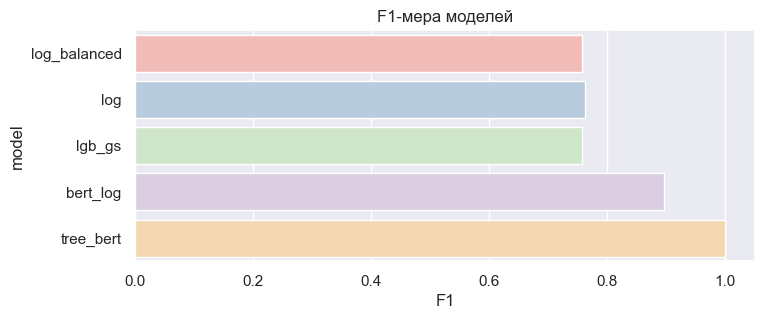

In [59]:
sns.set (font_scale= 1 )
plt.figure(figsize=[8,3])
plt.title('F1-мера моделей')
ax = sns.barplot(x='F1', y="model", data=dt,  palette='Pastel1')

 <b>Вывод:</b> Среди построенных моделей  установленная метрика качества F1-мера превысила требуемый показатель (0.75) у всех моделей.

Самая высокая F1-мера (1.00) достигнута у Дерева решений, признаки которой преобразованы нейронной сетью BERT. Вместе с тем, данная метрика выглядит неправдоподобно высокой.
    
У Логистической регрессии, также построенной с помощью BERT, метрика F1-мера составила 0.896, что более реалистично. Также у нее высокая скорость обучения. Для проверки на тесте ее и выберем.

### Тестирование

Получаем предсказания Логистической регрессии, построенной с использованием  BERT,   выводим значение F1-меры.

In [62]:
bert_log_pred = bert_log.predict(X_test_bert) 
print("F1-мера:", round((f1_score(y_test_bert, bert_log_pred)),3))

F1-мера: 0.909


Проверка на тестовой выборке Логистической регрессии, построенной с использованием нейронной сети BERT показала, что значение  F1-меры несколько упало, однако все равно имеет высокое значение: 0.824, что превышает установленный порог 0.75. Данную модель и рекомендуем для внедрения.

## Выводы

 <b>Вывод:</b> 
По заказу Интернет-магазина «Викишоп» мы построили несколько моделей машинного обучения, способных распознавать негативные отзывы клиентов магазина для их модерации. Для обучения заказчиком предоставлен набор данных toxic_comments.csv, в которых комментарии размечены на позитивные и негативные, установлена метрика качества - F1, значение которой должно быть не меньше 0.75.
    
Поставленная задача представляет из себя построение модели машинного обучения, способной обрабатывать естественный язык. В исходном датасете 159292 объека, признак, представленный текстами комментариев (столбец'text') и целевой признак - классифицированная по бинарному типу разметка комментариев (столбец 'toxic'). В целевом признаке присутствует дисбаланс в соотношении 9:1 в сторону увеличения числа объектов отрицательного класса.
    
В ходе подготовки данных мы написали функцию, применив которую к столбцу 'text', очистили признак от лишних символов, цифр, привели слова к нижнему регистру, разбили текст на токены (слова), удалили слова, не несущие смысловой нагрузки (стоп-слова) и лемматизировали (привели слова к начальной форме).    

Мы построили модели машинного обучения, распознающие направленность текста, Логистическую регрессию без выравнивания классов и с аргументом class_weight='balanced', модели градиентного бустинга LGBMClassifier и CatBoostClassifier. Данные признака для этих моделей конвертированы методом Tfidfvectorizer().
    
Также построены две модели, признаки которых конвертированы нейронной сетью BERT: Логистическая регрессия и Дерево решений.Для этого использована предобученная на токсичные комментарии унитарная модель toxic-bert
    
Среди построенных моделей установленная метрика качества F1-мера превысила требуемый показатель (0.75) у всех моделей. 
    
Самая высокая F1-мера (1.00) достигнута у Дерева решений, признаки которой преобразованы нейронной сетью BERT. Вместе с тем, данная метрика выглядит неправдоподобно высокой. У Логистической регрессии, также построенной с помощью BERT, метрика F1-мера составила 0.896, что более реалистично. Также у нее высокая скорость обучения. Данная модель выбрана для тестирования.
    
Проверка работы Логистической регрессии, построенной с помощью BERT, на тестовой выборке показала, что F1-мера немного повысилась по сравнению с учебными данными и составила 0.909, что соответствует требованию заказчика (не менее 0.75). 
    
На основании проведенной работы в качестве модели машинного обучения, распознающей тональность отзывов клиентов, заказчику предлагается для внедрения модель Логистической регрессии, построенная с применением предобученной на токсичные комментарии унитарной модели toxic-bert, как имеющая высокую метрику качества и высокую скорость обучения.
    